## Downloading the dataset


In [ ]:
!git clone https://github.com/agikarasugi/HumanBinaryClassificationSuite/

Cloning into 'HumanBinaryClassificationSuite'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 6993 (delta 8), reused 28 (delta 2), pack-reused 6956
Receiving objects: 100% (6993/6993), 327.86 MiB | 24.66 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Checking out files: 100% (8549/8549), done.


## View sample images

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


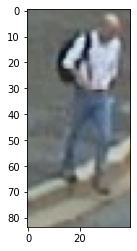

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/HumanBinaryClassificationSuite/dataset/human/1 (1).png')
imgplot = plt.imshow(img)
plt.show()

Populating the interactive namespace from numpy and matplotlib


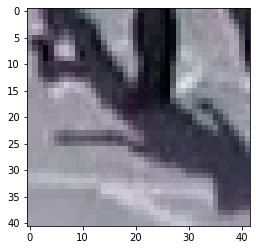

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/HumanBinaryClassificationSuite/dataset/nonhuman/1 (1).png')
imgplot = plt.imshow(img)
plt.show()

## Data Pre-processing

In [3]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np

dataset_path = './HumanBinaryClassificationSuite/dataset'

image_size_y = 50
image_size_x = 80

image_data = []
image_class = []

for i, dir in enumerate(os.listdir(dataset_path)):
    class_dir = (dataset_path + '/' + dir)
    for image in os.listdir(class_dir):
        image_file = class_dir + '/' + image
        img = cv2.imread(image_file)
        res = cv2.resize(img, dsize=(image_size_y, image_size_x), interpolation=cv2.INTER_CUBIC)
        image_data.append(res)
        image_class.append((i - 1) * -1)
        
image_data = np.array(image_data, dtype='float32')
image_class = np.array(image_class, dtype='float64')

train_image, test_image, train_label, test_label = train_test_split(image_data,
                                                                    image_class,
                                                                    test_size=0.2)

FileNotFoundError: ignored

In [ ]:
print(train_image.shape)

(6684, 80, 50, 3)


## Additional checkpoints imposed during learning

In [1]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.utils import plot_model
import os

class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, test_data, max_loss_to_save):
        self.test_data = test_data
        self.min_loss = 99.99
        self.max_loss_to_save = max_loss_to_save

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('>> Testing loss: {}, acc: {}'.format(loss, acc))
        
        if loss < self.min_loss:
            self.min_loss = loss
            
            if loss < self.max_loss_to_save:
                mnow = datetime.now()
                mdt_string = mnow.strftime("%d%m%Y-%H%M")
                
                mname = 'l{:4.0f}-a{:2.0f}-'.format(loss*10000, acc*100) + mdt_string
                
                filename = foldername + mname

                print('>> Saving model...')
                plot_model(model, to_file=(filename+'.jpg'), show_shapes=True)
                model.save(filename+'.h5')
        
        if loss > 0.50:
            print('>> Model probably overfitted, cancelling training...')
            self.model.stop_training = True

#Training the model

In [4]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu,
                            input_shape=(image_size_x, image_size_y, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu),
        tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu),
        tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 48, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 9, 64)         18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 2, 32)          1

In [ ]:
model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['acc'])
        



history = model.fit(train_image, train_label, epochs=20, 
                  validation_split=0.25, shuffle=True,
                  callbacks=[CustomModelCheckpoint((test_image, test_label), 0.2400)],
                           verbose=1)

model.save_weights('dumb-model.h5')        

Epoch 1/20
157/157 [==============================] - 16s 104ms/step - loss: 1.3225 - acc: 0.8231 - val_loss: 0.3724 - val_acc: 0.8588
Epoch 2/20
157/157 [==============================] - 16s 103ms/step - loss: 0.3687 - acc: 0.8655 - val_loss: 0.3443 - val_acc: 0.8624
Epoch 3/20
157/157 [==============================] - 16s 103ms/step - loss: 0.3384 - acc: 0.8691 - val_loss: 0.3453 - val_acc: 0.8636
Epoch 4/20
157/157 [==============================] - 16s 104ms/step - loss: 0.3060 - acc: 0.8843 - val_loss: 0.3277 - val_acc: 0.8624
Epoch 5/20
157/157 [==============================] - 20s 129ms/step - loss: 0.2707 - acc: 0.9001 - val_loss: 0.3134 - val_acc: 0.8839
Epoch 6/20
157/157 [==============================] - 16s 105ms/step - loss: 0.2571 - acc: 0.9066 - val_loss: 0.3173 - val_acc: 0.8737
Epoch 7/20
157/157 [==============================] - 16s 103ms/step - loss: 0.2314 - acc: 0.9156 - val_loss: 0.3321 - val_acc: 0.8659
Epoch 8/20
157/157 [==============================] - 1

In [ ]:
model.load_weights('dumb-model.h5')

# Analysing the model

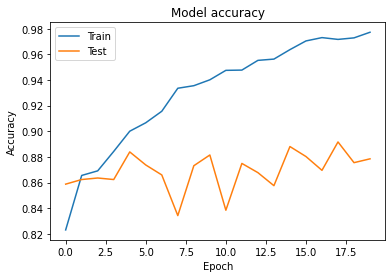

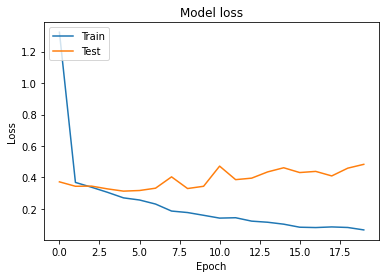

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('train_gacc.png', dpi=64)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('train_gloss.png', dpi=64)
plt.show()